In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from constants import *
from phe import pickle, query

In [3]:
date = 'date'
ltla = 'ltla'
nation = 'nation'

In [3]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_tests_by_publish_date]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newTestsByPublishDate
0,2020-11-17,2020-11-17,United Kingdom,K02000001,NaN,NaN,NaN,NaN
1,2020-11-17,2020-11-16,United Kingdom,K02000001,2983.0,NaN,103.0,236629.0
2,2020-11-17,2020-11-15,United Kingdom,K02000001,12693.0,NaN,260.0,284662.0
3,2020-11-17,2020-11-14,United Kingdom,K02000001,16723.0,NaN,273.0,344679.0
4,2020-11-17,2020-11-13,United Kingdom,K02000001,23648.0,1601.0,306.0,385916.0
...,...,...,...,...,...,...,...,...
315,2020-11-17,2020-01-07,United Kingdom,K02000001,NaN,NaN,NaN,NaN
316,2020-11-17,2020-01-06,United Kingdom,K02000001,NaN,NaN,NaN,NaN
317,2020-11-17,2020-01-05,United Kingdom,K02000001,NaN,NaN,NaN,NaN
318,2020-11-17,2020-01-04,United Kingdom,K02000001,NaN,NaN,NaN,NaN


In [10]:
pickle('overview', overview_data)

'~/Downloads/phe_overview_2020-11-17_2020-11-18-09-22.pickle'

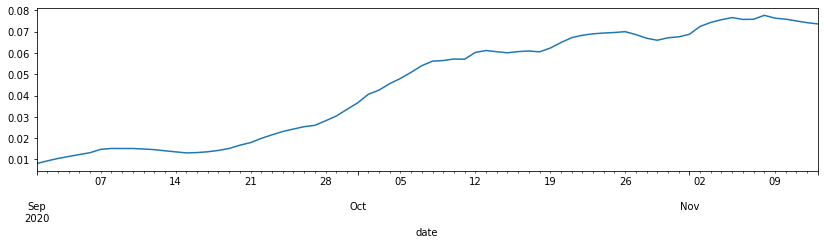

In [11]:
overview_data.index = pd.to_datetime(overview_data[date])
overview_data.sort_index(inplace=True)
smoothed_overview_data = overview_data.rolling(window=7).mean()
cases_per_test = (smoothed_overview_data[new_cases_by_specimen_date] / smoothed_overview_data[new_tests_by_publish_date])
cases_per_test.loc['2020-09-01':datetime.now()-timedelta(days=5)].plot(figsize=(14,3))
plt.gcf().set_facecolor('white')

In [12]:
nation_data = query(
    filters={area_type: nation}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date]
)
nation_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate
0,2020-11-17,2020-11-17,England,E92000001,4.0,NaN
1,2020-11-17,2020-11-16,England,E92000001,2162.0,92.0
2,2020-11-17,2020-11-15,England,E92000001,11209.0,240.0
3,2020-11-17,2020-11-14,England,E92000001,14902.0,251.0
4,2020-11-17,2020-11-13,England,E92000001,21277.0,266.0
...,...,...,...,...,...,...
1275,2020-11-17,2020-01-07,Wales,W92000004,NaN,NaN
1276,2020-11-17,2020-01-06,Wales,W92000004,NaN,NaN
1277,2020-11-17,2020-01-05,Wales,W92000004,NaN,NaN
1278,2020-11-17,2020-01-04,Wales,W92000004,NaN,NaN


In [13]:
pickle('nation', nation_data)

'~/Downloads/phe_nation_2020-11-17_2020-11-18-09-22.pickle'

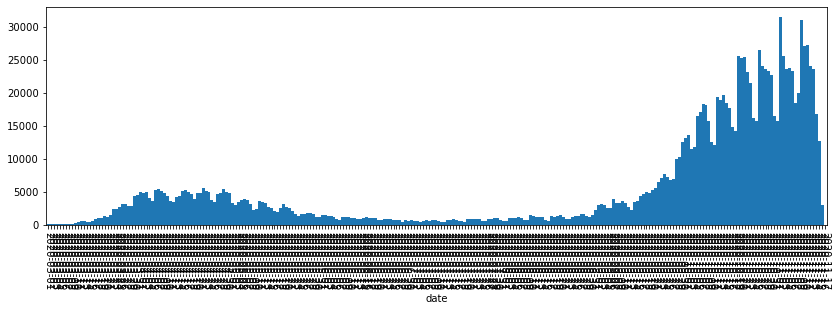

In [14]:
nation_data.groupby(date).sum()[new_cases_by_specimen_date].loc['2020-03-01':].plot(kind='bar', stacked=True, width=1, rot=-90, figsize=(14, 4))

In [15]:
area_data = query(
    filters={area_type: ltla}, 
    structure=[release_timestamp, date, area_name, area_code, new_cases_by_specimen_date, new_deaths_by_death_date],
    max_workers=10
)
area_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newDeaths28DaysByDeathDate
0,2020-11-17,2020-11-17,Aberdeen City,S12000033,NaN,NaN
1,2020-11-17,2020-11-16,Aberdeen City,S12000033,5.0,0.0
2,2020-11-17,2020-11-15,Aberdeen City,S12000033,10.0,1.0
3,2020-11-17,2020-11-14,Aberdeen City,S12000033,13.0,0.0
4,2020-11-17,2020-11-13,Aberdeen City,S12000033,23.0,0.0
...,...,...,...,...,...,...
121915,2020-11-17,2020-01-07,York,E06000014,NaN,NaN
121916,2020-11-17,2020-01-06,York,E06000014,NaN,NaN
121917,2020-11-17,2020-01-05,York,E06000014,NaN,NaN
121918,2020-11-17,2020-01-04,York,E06000014,NaN,NaN


In [16]:
pickle('area', area_data)

'~/Downloads/phe_area_2020-11-17_2020-11-18-09-23.pickle'